# Homework week 4 Machine Learning Zoomcamp

## Author: Sebastián Ayala Ruano 

In [201]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold


Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [202]:
df = pd.read_csv('../Data/CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [203]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [204]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [205]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [206]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [207]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int64
dtype: object

In [208]:
numerical = ["seniority", "time", "age", "expenses", "income", "assets", "debt", "amount", "price"]
categorical = ["home", "marital", "records", "job"]

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [209]:
# Create test and full training partitions 
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [210]:
# Create train and validation partitions 
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [211]:
# Verify the lenght of partitions 
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [212]:
# Reset indices of all partitions 
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train_full = df_train_full.reset_index(drop=True)

In [213]:
# Extract target variable of all partitions 
y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

In [214]:
# Delete target variable for all partitions 
del df_train['default']
del df_val['default']
del df_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [215]:
# Calculate ROC AUC for numerical variables 
for i in numerical:
    AUROC_temp = roc_auc_score(y_train, df_train[i])
    if AUROC_temp < 0.5:
        AUROC_temp = roc_auc_score(y_train, -df_train[i])
    print(f'AUROC of {i}: {AUROC_temp}')

AUROC of seniority: 0.7093778624491943
AUROC of time: 0.5608662489595051
AUROC of age: 0.5732933272499939
AUROC of expenses: 0.5009184217217011
AUROC of income: 0.682006666132633
AUROC of assets: 0.6486042567122802
AUROC of debt: 0.5047829675783548
AUROC of amount: 0.5910773431595518
AUROC of price: 0.5043329862114843


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

**Answer:** Seniority has the hightest AUC

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [217]:
# Select features 
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']
df_train_small = df_train[features]
df_test_small = df_test[features]
df_val_small = df_val[features]

In [218]:
# Create dictionaries of the training data to apply one-hot enconding on categorical fatures 
train_dict = df_train_small.to_dict(orient='records')

In [219]:
# Create feature matrix with numerical and one-hot encoded categorical variables
dv = DictVectorizer()
X_train_small = dv.fit_transform(train_dict)

In [220]:
# Fit and train logistic regression model 
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_small, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [221]:
# Create feature matrix of validation partition 
val_dict = df_val_small.to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

In [222]:
# Make predictions on the validation dataset 
y_pred = model.predict_proba(X_val)[:, 1]

In [224]:
# Obtain AUC 
AUC_val = round(roc_auc_score(y_val, y_pred),3)
print(AUC_val)

0.812


## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- **0.812**

**Answer:** The AUC of the model on the validation dataset is 0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [225]:
# Function to obtain a dataframe with TN, FN, FP, TP, precision, and recall values
# at thresholds from 0.0 to 1.0 with step 0.01
def pr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    
    return df_scores

In [226]:
# Obtain the dataframe with 
df_pr_curve = pr_dataframe(y_val, y_pred)

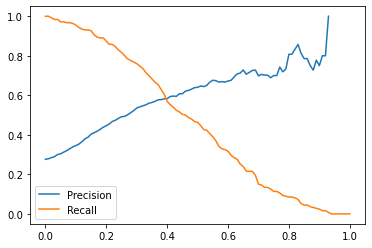

In [227]:
# Create the PR curve 
plt.plot(df_pr_curve.threshold, df_pr_curve['precision'], label='Precision')
plt.plot(df_pr_curve.threshold, df_pr_curve['recall'], label='Recall')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* **0.4**
* 0.6
* 0.8

**Answer:** Precision and recall curves intersect at 0.4 threshold.

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [228]:
df_pr_curve["F1_score"] = 2*(df_pr_curve["precision"]*df_pr_curve["recall"])/(df_pr_curve["precision"]+df_pr_curve["recall"])

In [229]:
df_pr_curve[df_pr_curve["F1_score"] == df_pr_curve.F1_score.max()]

,threshold,tp,fp,fn,tn,precision,recall,F1_score
30,0.3,187,162,59,483,0.535817,0.760163,0.628571


At which threshold F1 is maximal?

- 0.1
- **0.3**
- 0.5
- 0.7

**Answer:** F1 socre is maximal at 0.3 threshold

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [230]:
# Function for training a LogReg model
def train(df_train, y_train, C=1.0):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [231]:
# Function for predicting values 
def predict(df, dv, model):
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [232]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f'Mean: {round(np.mean(scores),4)}\n Std: {round(np.std(scores),4)}')

Mean: 0.8142
 Std: 0.0146


How large is standard devidation of the scores across different folds?

- 0.001
- **0.014**
- 0.09
- 0.14

**Answer:** The std across different folds is 0.014

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std

In [235]:
for C in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.809 +- 0.013
C=0.1 0.813 +- 0.014
C=1 0.814 +- 0.015
C=10 0.812 +- 0.014


Which C leads to the best mean score?

- 0.01
- 0.1
- **1**
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

**Answer:** The C with the best mean score is 1.

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.